In [15]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the dataset
dataset_path = "Facebook_Marketplace_data.csv"  # Update this if the dataset is in a different location
try:
    df = pd.read_csv(dataset_path)
except FileNotFoundError:
    raise FileNotFoundError(f"The file at {dataset_path} was not found. Please check the path.")

In [16]:
# Preview the dataset
print("Preview of the dataset:")
print(df.head())

# Handle missing values (e.g., filling with 0 or other strategies)
df = df.fillna(0)

# Ensure at least one row remains after preprocessing
if df.empty:
    raise ValueError("Dataset is empty after handling missing values.")

# Convert status_published to datetime and extract useful time-based features
df['status_published'] = pd.to_datetime(df['status_published'], errors='coerce')
df['hour'] = df['status_published'].dt.hour  # Extract the hour of posting
df['day_of_week'] = df['status_published'].dt.dayofweek  # Extract the day of the week (0=Monday, 6=Sunday)

Preview of the dataset:
   status_id status_type status_published  num_reactions  num_comments  \
0          1       video   4/22/2018 6:00            529           512   
1          2       photo  4/21/2018 22:45            150             0   
2          3       video   4/21/2018 6:17            227           236   
3          4       photo   4/21/2018 2:29            111             0   
4          5       photo   4/18/2018 3:22            213             0   

   num_shares  num_likes  num_loves  num_wows  num_hahas  num_sads  \
0         262        432         92         3          1         1   
1           0        150          0         0          0         0   
2          57        204         21         1          1         0   
3           0        111          0         0          0         0   
4           0        204          9         0          0         0   

   num_angrys  Column1  Column2  Column3  Column4  
0           0      NaN      NaN      NaN      NaN  
1     

In [17]:
print("Dataset after preprocessing:")
print(df.head())

Dataset after preprocessing:
   status_id status_type    status_published  num_reactions  num_comments  \
0          1       video 2018-04-22 06:00:00            529           512   
1          2       photo 2018-04-21 22:45:00            150             0   
2          3       video 2018-04-21 06:17:00            227           236   
3          4       photo 2018-04-21 02:29:00            111             0   
4          5       photo 2018-04-18 03:22:00            213             0   

   num_shares  num_likes  num_loves  num_wows  num_hahas  num_sads  \
0         262        432         92         3          1         1   
1           0        150          0         0          0         0   
2          57        204         21         1          1         0   
3           0        111          0         0          0         0   
4           0        204          9         0          0         0   

   num_angrys  Column1  Column2  Column3  Column4  hour  day_of_week  
0           0   

In [18]:
def analyze_time_impact(df):
    """
    Question 1: How does the time of upload (status_published) affect the num_reaction?
    """
    print("\nQuestion 1: Time Impact Analysis")
    print("================================")
    hourly_reactions = df.groupby('hour')['num_reactions'].agg(['mean', 'count']).round(2)
    print("\nAverage reactions by hour of day:")
    print(hourly_reactions)
    plt.figure(figsize=(12, 6))
    plt.plot(hourly_reactions.index, hourly_reactions['mean'], marker='o')
    plt.title('Average Number of Reactions by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Number of Reactions')
    plt.grid(True)
    plt.show()
    daily_reactions = df.groupby('day_of_week')['num_reactions'].agg(['mean', 'count']).round(2)
    print("\nAverage reactions by day of week (0=Monday, 6=Sunday):")
    print(daily_reactions)
    best_hours = hourly_reactions.nlargest(3, 'mean')
    print("\nBest hours to post (highest average reactions):")
    print(best_hours)

In [19]:
def analyze_correlations(df):
    """
    Question 2: Analyze correlations between engagement metrics
    """
    print("\nQuestion 2: Correlation Analysis")
    print("================================")

    engagement_metrics = ['num_reactions', 'num_comments', 'num_shares']
    correlation_matrix = df[engagement_metrics].corr()

    print("\nCorrelation Matrix:")
    print(correlation_matrix.round(3))

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap of Engagement Metrics')
    plt.show()

    print("\nDetailed correlation interpretation:")
    correlations = []
    for i in range(len(engagement_metrics)):
        for j in range(i+1, len(engagement_metrics)):
            metric1 = engagement_metrics[i]
            metric2 = engagement_metrics[j]
            corr = correlation_matrix.iloc[i, j]
            correlations.append((metric1, metric2, corr))

    for metric1, metric2, corr in correlations:
        strength = "strong" if abs(corr) > 0.7 else "moderate" if abs(corr) > 0.3 else "weak"
        direction = "positive" if corr > 0 else "negative"
        print(f"- {metric1} and {metric2}: {strength} {direction} correlation ({corr:.3f})")

In [20]:
def perform_kmeans_clustering(df):
    """
    Question 3 & 4: K-means clustering and finding optimal number of clusters
    """
    print("\nQuestions 3 & 4: K-means Clustering Analysis")
    print("===========================================")

    features = ['num_reactions', 'num_comments', 'num_shares', 'num_likes',
               'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    inertias = []
    K = range(1, 11)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('k (number of clusters)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    optimal_k = 3
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df['cluster'] = kmeans.fit_predict(X_scaled)
    print("\nCluster Analysis:")
    cluster_stats = df.groupby('cluster')[features].mean().round(2)
    print("\nCluster Centers (average values):")
    print(cluster_stats)
    plt.figure(figsize=(10, 6))
    plt.scatter(df['num_reactions'], df['num_comments'], c=df['cluster'], cmap='viridis')
    plt.xlabel('Number of Reactions')
    plt.ylabel('Number of Comments')
    plt.title('Clusters of Posts based on Engagement')
    plt.show()

In [21]:
def analyze_post_types(df):
    """
    Questions 5 & 6: Analyze post types and their engagement metrics
    """
    print("\nQuestions 5 & 6: Post Type Analysis")
    print("==================================")
    post_type_counts = df['status_type'].value_counts()
    print("\nCount of different post types:")
    print(post_type_counts)
    engagement_metrics = ['num_reactions', 'num_comments', 'num_shares']
    avg_metrics = df.groupby('status_type')[engagement_metrics].mean().round(2)
    print("\nAverage engagement metrics by post type:")
    print(avg_metrics)
    plt.figure(figsize=(10, 6))
    post_type_counts.plot(kind='bar')
    plt.title('Distribution of Post Types')
    plt.xlabel('Post Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    avg_metrics.plot(kind='bar', figsize=(12, 6))
    plt.title('Average Engagement Metrics by Post Type')
    plt.xlabel('Post Type')
    plt.ylabel('Average Count')
    plt.legend(title='Metric')
    plt.xticks(rotation=45)
    plt.show()


Question 1: Time Impact Analysis

Average reactions by hour of day:
        mean  count
hour               
0     261.84    380
1     203.32    814
2     163.91    617
3     290.27    433
4     242.69    382
5     293.87    372
6     340.21    394
7     183.30    839
8     204.80    709
9     205.78    447
10    234.51    240
11    180.64    147
12    196.05     93
13    176.88     48
14    261.33     18
15    341.67     12
16    283.25      4
17    384.00      4
18    351.75      4
19    442.37     19
20    417.29     59
21    261.91    152
22    238.38    444
23    244.28    419


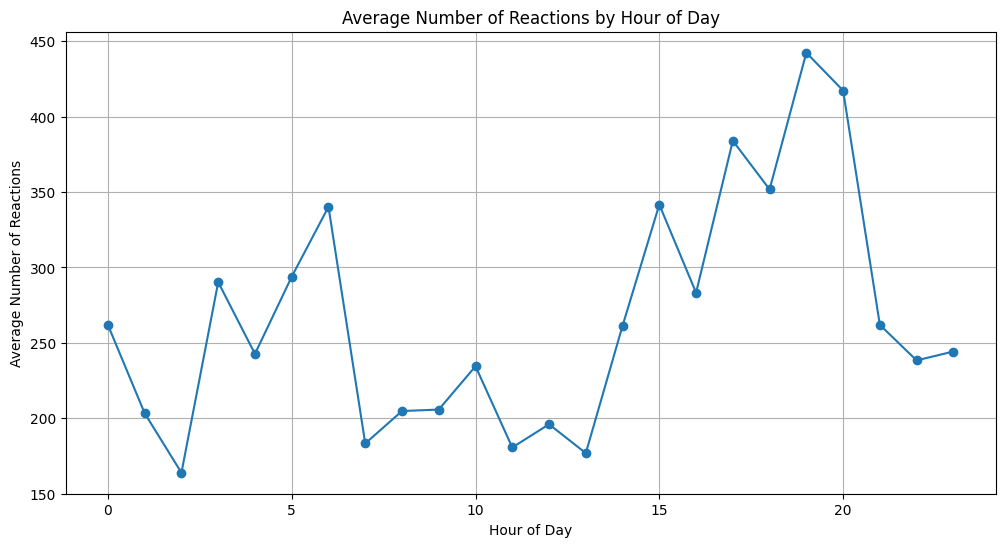


Average reactions by day of week (0=Monday, 6=Sunday):
               mean  count
day_of_week               
0            207.20    994
1            197.30   1041
2            245.39    981
3            262.70    983
4            232.36   1010
5            233.21    982
6            234.49   1059

Best hours to post (highest average reactions):
        mean  count
hour               
19    442.37     19
20    417.29     59
17    384.00      4

Question 2: Correlation Analysis

Correlation Matrix:
               num_reactions  num_comments  num_shares
num_reactions          1.000         0.151       0.251
num_comments           0.151         1.000       0.641
num_shares             0.251         0.641       1.000


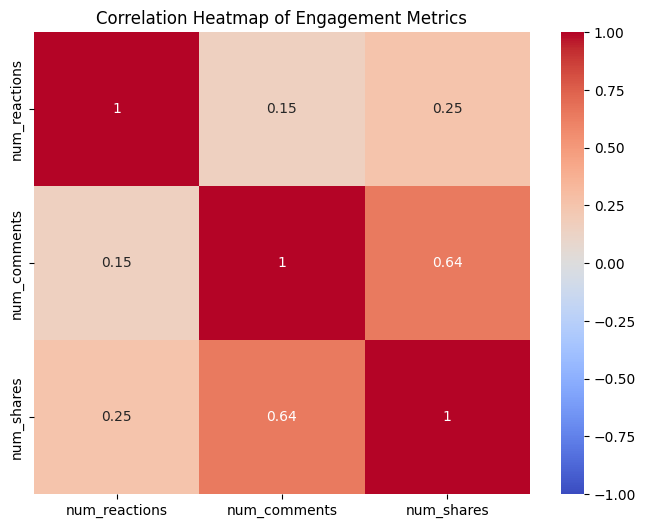


Detailed correlation interpretation:
- num_reactions and num_comments: weak positive correlation (0.151)
- num_reactions and num_shares: weak positive correlation (0.251)
- num_comments and num_shares: moderate positive correlation (0.641)

Questions 3 & 4: K-means Clustering Analysis


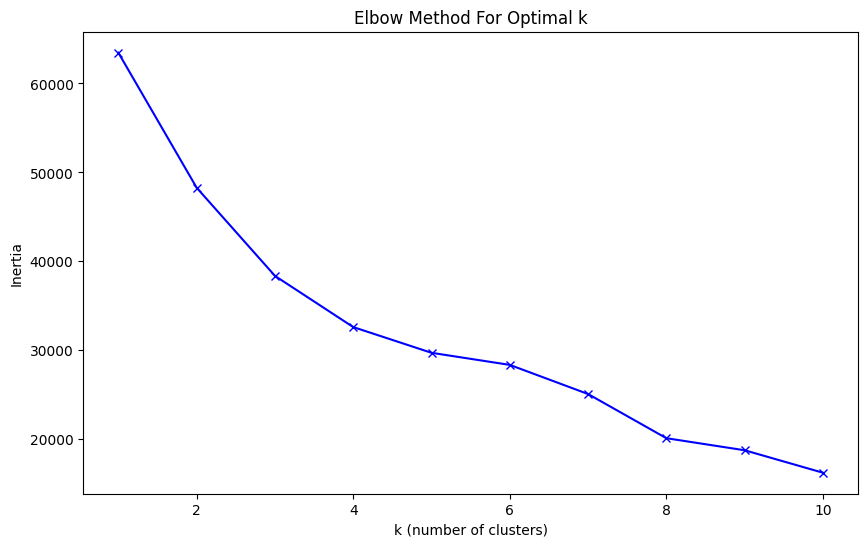


Cluster Analysis:

Cluster Centers (average values):
         num_reactions  num_comments  num_shares  num_likes  num_loves  \
cluster                                                                  
0               113.85        106.23       21.71     105.29       7.46   
1               786.87       3217.95      508.30     606.29     149.34   
2              1823.31         61.33       11.65    1817.53       3.10   

         num_wows  num_hahas  num_sads  num_angrys  
cluster                                             
0            0.55       0.34      0.15        0.05  
1           17.08       9.75      2.76        1.65  
2            2.44       0.20      0.03        0.01  


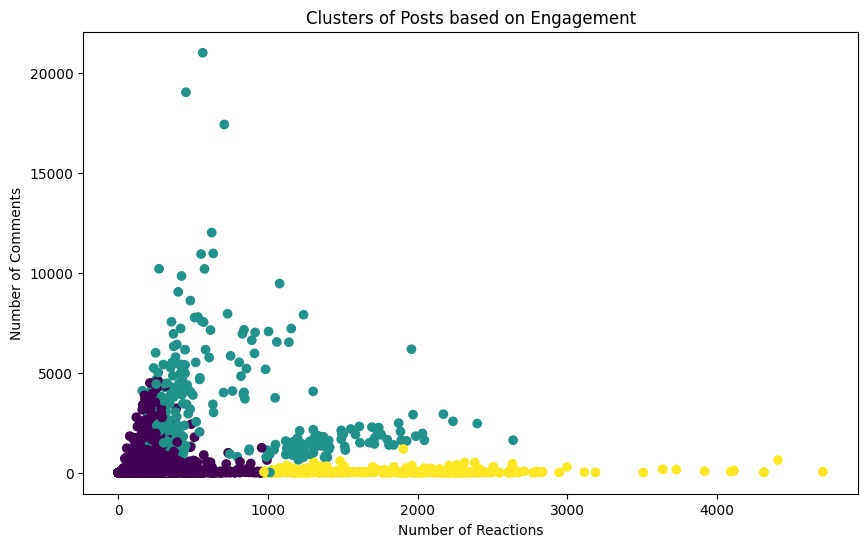


Questions 5 & 6: Post Type Analysis

Count of different post types:
status_type
photo     4288
video     2334
status     365
link        63
Name: count, dtype: int64

Average engagement metrics by post type:
             num_reactions  num_comments  num_shares
status_type                                         
link                370.14          5.70        4.40
photo               181.29         15.99        2.55
status              438.78         36.24        2.56
video               283.41        642.48      115.68


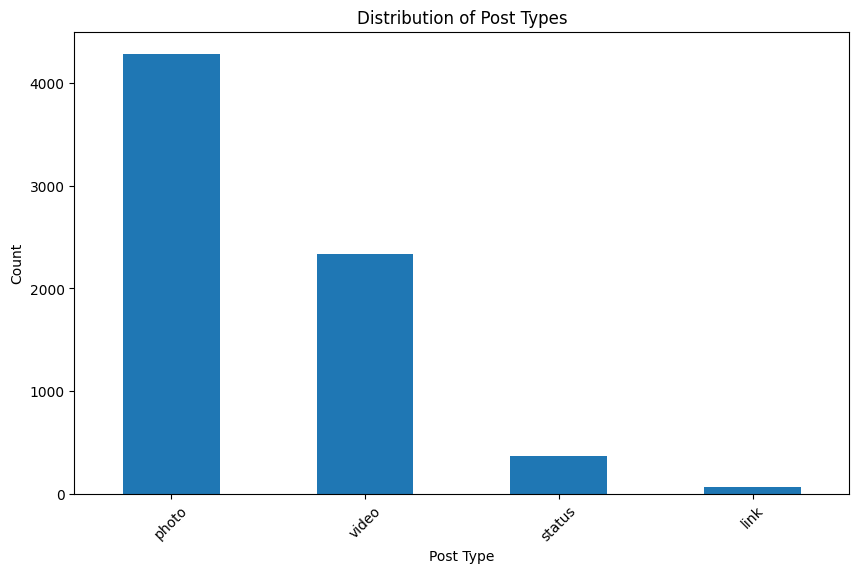

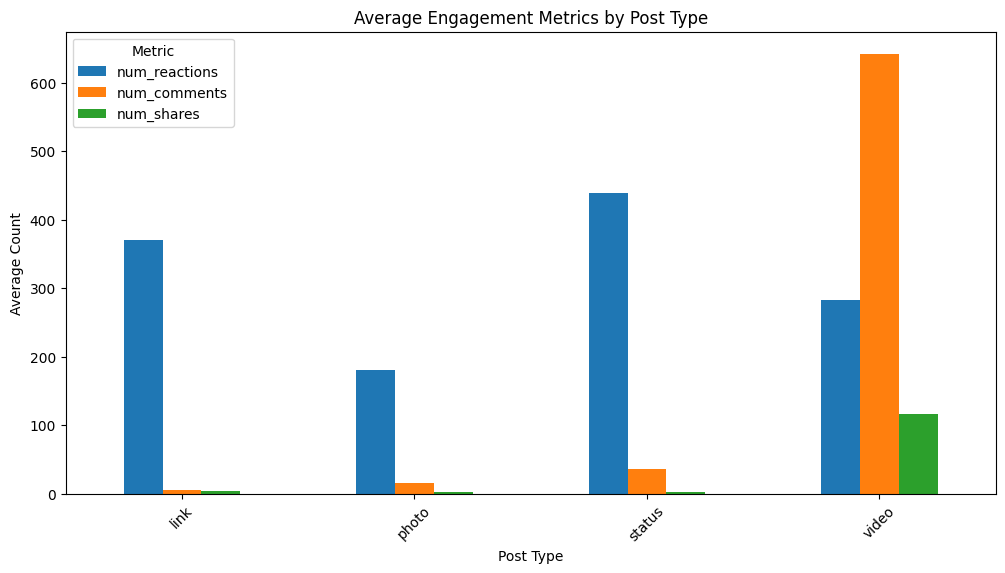

In [22]:
def main():
    analyze_time_impact(df)
    analyze_correlations(df)
    perform_kmeans_clustering(df)
    analyze_post_types(df)

if __name__ == "__main__":
    main()